In [30]:
# neural_ode_pure_jax.py
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

In [ ]:
# Enable 64-bit precision for better numerical stability
# jax.config.update("jax_enable_x64", True)

In [ ]:
class NeuralODE:
    def __init__(self, hidden_dim=64, learning_rate=1e-3):
        """
        Initialize Neural ODE with a simple MLP as the dynamics function f(y, t)
        
        The ODE we're learning: dy/dt = f(y, t) where f is a neural network
        """
        self.hidden_dim = hidden_dim
        
        # Initialize network parameters using JAX's random number generator
        key = jax.random.PRNGKey(42)
        key1, key2, key3 = jax.random.split(key, 3)
        
        # Network architecture: 2 inputs (y, t) -> hidden_dim -> 1 output (dy/dt)
        self.params = {
            'w1': jax.random.normal(key1, (2, hidden_dim)) * 0.1,
            'b1': jax.random.normal(key2, (hidden_dim,)) * 0.1,
            'w2': jax.random.normal(key3, (hidden_dim, 1)) * 0.1,
            'b2': jnp.zeros((1,))
        }
        
        self.optimizer = optax.adam(learning_rate)
        self.opt_state = self.optimizer.init(self.params)
    
    def dynamics_fn(self, params, y, t):
        """
        Defines the right-hand side of our ODE: dy/dt = f(y, t)
        
        Args:
            params: neural network parameters
            y: state variable (scalar)
            t: time variable (scalar)
        
        Returns:
            dy/dt: time derivative of y
        """
        # Combine y and t into input features
        inputs = jnp.array([y, t])
        
        # Forward pass through the network
        hidden = jnp.tanh(jnp.dot(inputs, params['w1']) + params['b1'])
        output = jnp.dot(hidden, params['w2']) + params['b2']
        
        return output[0]  # Return scalar
    
    def euler_integrate(self, params, y0, t_eval):
        """
        Solve ODE using Euler method: y_{n+1} = y_n + h * f(y_n, t_n)
        
        Args:
            params: neural network parameters
            y0: initial condition
            t_eval: time points where we want the solution
            
        Returns:
            trajectory: solution y(t) at each time in t_eval
        """
        trajectory = [y0]
        y_current = y0
        
        for i in range(len(t_eval) - 1):
            t_current = t_eval[i]
            dt = t_eval[i + 1] - t_current
            
            # Euler step: y_{n+1} = y_n + dt * f(y_n, t_n)
            dy_dt = self.dynamics_fn(params, y_current, t_current)
            y_next = y_current + dt * dy_dt
            
            trajectory.append(y_next)
            y_current = y_next
        
        return jnp.array(trajectory)
    
    @partial(jax.jit, static_argnums=(0,))
    def loss_fn(self, params, y0, t_eval, y_true):
        """
        Compute mean squared error between predicted and true trajectories
        """
        y_pred = self.euler_integrate(params, y0, t_eval)
        return jnp.mean((y_pred - y_true) ** 2)
    
    @partial(jax.jit, static_argnums=(0,))
    def update_step(self, params, opt_state, y0, t_eval, y_true):
        """
        Single training step: compute gradients and update parameters
        """
        loss, grads = jax.value_and_grad(self.loss_fn)(params, y0, t_eval, y_true)
        updates, new_opt_state = self.optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        
        return new_params, new_opt_state, loss

In [33]:
def generate_synthetic_data(t_eval):
    """
    Generate true trajectory: y(t) = sin(t)
    """
    return jnp.sin(t_eval)

In [34]:

def train_and_visualize():
    # Create time points for evaluation
    t_eval = jnp.linspace(0, 2 * jnp.pi, 100)  # From 0 to 2π
    
    # Generate true data
    y_true = generate_synthetic_data(t_eval)
    y0 = y_true[0]  # Initial condition: sin(0) = 0
    
    # Initialize Neural ODE
    node = NeuralODE(hidden_dim=64, learning_rate=1e-2)
    
    # Training loop
    num_epochs = 2000
    print_interval = 100
    
    # Store trajectories for visualization
    trajectories = []
    losses = []
    
    print("Training Neural ODE with Pure JAX...")
    for epoch in range(num_epochs):
        # Training step
        node.params, node.opt_state, loss = node.update_step(
            node.params, node.opt_state, y0, t_eval, y_true
        )
        
        losses.append(loss)
        
        if epoch % print_interval == 0:
            # Store trajectory for visualization
            y_pred = node.euler_integrate(node.params, y0, t_eval)
            trajectories.append((epoch, y_pred))
            print(f"Epoch {epoch}, Loss: {loss:.6f}")
    
    # Final prediction
    y_pred_final = node.euler_integrate(node.params, y0, t_eval)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Final prediction vs true data
    plt.subplot(1, 3, 1)
    plt.plot(t_eval, y_true, 'b-', label='True: sin(t)', linewidth=2)
    plt.plot(t_eval, y_pred_final, 'r--', label='Predicted', linewidth=2)
    plt.xlabel('Time t')
    plt.ylabel('y(t)')
    plt.title('Final Prediction')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Training loss
    plt.subplot(1, 3, 2)
    plt.plot(losses)
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss')
    plt.grid(True)
    
    # Plot 3: Learning progression
    plt.subplot(1, 3, 3)
    plt.plot(t_eval, y_true, 'b-', label='True', linewidth=3)
    for i, (epoch, traj) in enumerate(trajectories):
        alpha = 0.3 + 0.7 * (i / len(trajectories))
        plt.plot(t_eval, traj, 'r--', alpha=alpha, label=f'Epoch {epoch}' if i % 2 == 0 else "")
    plt.xlabel('Time t')
    plt.ylabel('y(t)')
    plt.title('Learning Progression')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('neural_ode_pure_jax.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return node, t_eval, y_true, y_pred_final

Training Neural ODE with Pure JAX...
Epoch 0, Loss: 0.621293
Epoch 100, Loss: 0.124475
Epoch 200, Loss: 0.039866
Epoch 300, Loss: 0.023137
Epoch 400, Loss: 0.056521
Epoch 500, Loss: 0.013412
Epoch 600, Loss: 0.226004
Epoch 700, Loss: 0.012556
Epoch 800, Loss: 0.006524
Epoch 900, Loss: 0.019569
Epoch 1000, Loss: 0.007512
Epoch 1100, Loss: 0.004058
Epoch 1200, Loss: 0.006716
Epoch 1300, Loss: 0.002865
Epoch 1400, Loss: 0.003499
Epoch 1500, Loss: 0.004831
Epoch 1600, Loss: 0.071078
Epoch 1700, Loss: 0.002787
Epoch 1800, Loss: 0.023374
Epoch 1900, Loss: 0.001931


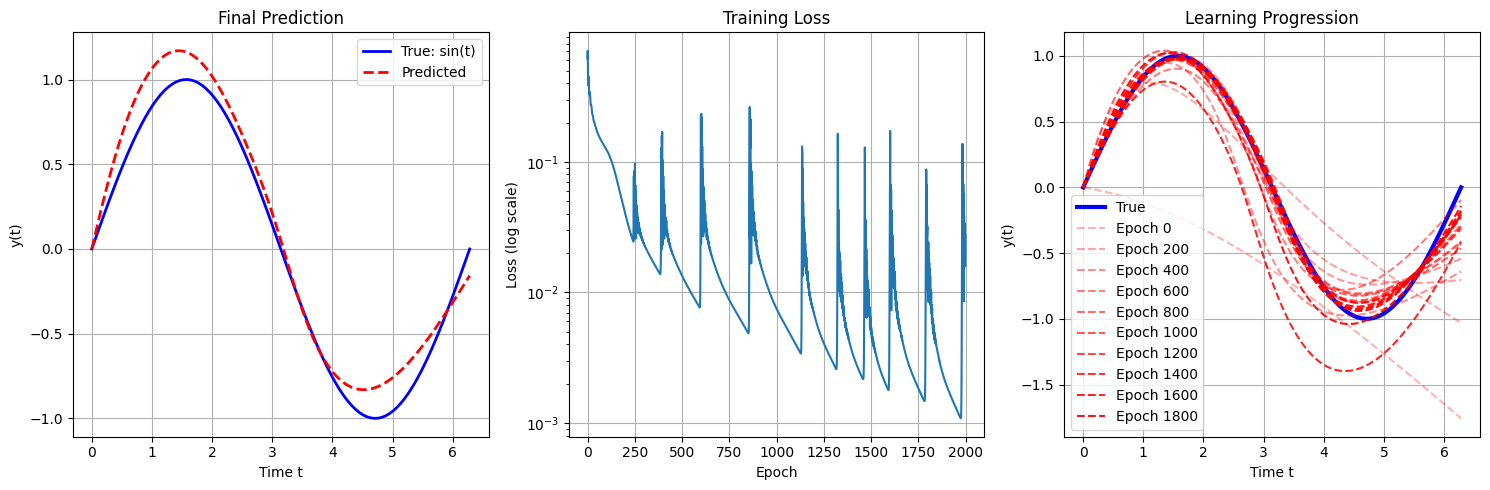

In [35]:
if __name__ == "__main__":
    model, t_eval, y_true, y_pred = train_and_visualize()